# Lung Cancer Survival Period Prediction: Classification

Starting with importing the datset from a.csv file and replacing entries with codes representing missing values. We aslo drop any rows with missing values in either Diagnosis year (YEAR_DX) or Survival Time in Months (SRV_TIME_MON) as these values directly affect the target variable and hence, removed from model training.

In [1]:
import pandas as pd

lung_cancer=pd.read_csv('final_respiratory_cancer.csv',index_col=0)

C:\Users\Admiral0295\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (134,135,136,137,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
lung_cancer.replace(to_replace={'MAR_STAT':9,'RACE1V':99,'AGE_DX':999,'SEQ_NUM':99,
                                  'Lateral':9,'GRADE':9,'DX_CONF':9,'CSEXTEN':999,
                                  'CSLYMPHN':999,'DAJCCT':88,'DAJCCN':88,'DAJCCM':88,
                                  'SURGSCOF':9,'SURGSITF':9,'NO_SURG':9,'AGE_1REC':99,
                                  'RAC_RECA':9,'RAC_RECY':9,'HST_STGA':9,'INTPRIM':9,
                                  'ERSTATUS':9,'PRSTATUS':9,'SRV_TIME_MON':9999,'SRV_TIME_MON_FLAG':9,
                                  'HER2':9,'BRST_SUB':9,'MALIGCOUNT':99,'BENBORDCOUNT':99,
                                  'RAD_SURG':9},value=pd.np.nan,inplace=True)

In [3]:
lung_cancer.replace({'EOD10_PN':{95:pd.np.nan,96:pd.np.nan,97:pd.np.nan,98:pd.np.nan,99:pd.np.nan},
                       'EOD10_NE':{95:pd.np.nan,96:pd.np.nan,97:pd.np.nan,98:pd.np.nan,99:pd.np.nan},
                       'CSTUMSIZ':{990:0,991:10,992:20,993:30,994:40,995:50,996:pd.np.nan,997:pd.np.nan,998:pd.np.nan,
                                   999:pd.np.nan,888:pd.np.nan},
                       'DAJCCSTG':{88:pd.np.nan,90:pd.np.nan,99:pd.np.nan},
                       'DSS1977S':{8:pd.np.nan,9:pd.np.nan},'SURGPRIF':{90:pd.np.nan,98:pd.np.nan,99:pd.np.nan},
                       'ADJTM_6VALUE':{88:pd.np.nan,99:pd.np.nan},'ADJNM_6VALUE':{88:pd.np.nan,99:pd.np.nan},
                       'ADJM_6VALUE':{88:pd.np.nan,99:pd.np.nan},'ADJAJCCSTG':{88:pd.np.nan,90:pd.np.nan,99:pd.np.nan}
                       },inplace=True)

We are looking for % Missing in each column of the dataset. Those columns with more than 20% missing, are measured across different timeframes or not related measurements to this type of cancer. Hence, they are removed.

In [4]:
lung_cancer.dropna(axis=0,how='any',subset=['YEAR_DX','SRV_TIME_MON'],inplace=True)

columns=lung_cancer.isna().sum(axis=0)/len(lung_cancer)

columns_list=list(columns[columns<0.2].index)

lung_cancer=lung_cancer.filter(items=columns_list,axis=1)

stats=lung_cancer.describe().loc['50%']
catg=lung_cancer.mode()

In [5]:
drop_cols=['MDXRECMP','YEAR_DX','CSVFIRST','CSVLATES','CSVCURRENT','ICCC3WHO',
           'ICCC3XWHO','CODPUB','CODPUBKM','STAT_REC','IHSLINK','VSRTSADX','ODTHCLASS',
           'CSTSEVAL','CSRGEVAL','CSMTEVAL','ST_CNTY','SRV_TIME_MON','SRV_TIME_MON_FLAG',
           '1year_survival','5year_survival']
catg_cols=['REG','MAR_STAT','RACE1V','SEX','PRIMSITE','LATERAL','BEHO2V', 'BEHO3V',
           'DX_CONF','REPT_SRC','CSMETSDX','DAJCCT','DAJCCN','DAJCCM','DAJCCSTG','DSS1977S',
           'SCSSM2KO','SURGPRIF','SURGSCOF','SURGSITF','NO_SURG','TYPE_FU','AGE_1REC','SITERWHO',
           'ICDOTO9V','ICDOT10V','BEHTREND','HISTREC','HISTRECB','CS0204SCHEMA','RAC_RECA',
           'RAC_RECY','ORIGRECB','HST_STGA','FIRSTPRM','SUMM2K','AYASITERWHO','LYMSUBRWHO',
           'INTPRIM','CSSCHEMA','ANNARBOR','RADIATNR','RAD_SURG','CHEMO_RX_REC']
num_cols=['AGE_DX','YR_BRTH','SEQ_NUM','EOD10_NE','CSEXTEN','CSLYMPHN','HISTO2V',
          'HISTO3V','CS1SITE','CS25SITE','REC_NO','MALIGCOUNT','BENBORDCOUNT']

Now, we are treating all the other columns for their missing values. For the categorical variables, the missing values are filled with the mode while the median is used for Quantitative Variables. The columns which directly affect the target variable or are irrelevant to this type of cancer from domain knowledge are removed.

In addition, classes of survival months are created for prediction.

In [6]:
values=dict()
for i in catg_cols:
    values[i]=catg[i][0]
for i in num_cols:
    values[i]=stats[i]

lung_cancer.fillna(value=values,inplace=True)

lung_cancer['survival_classes']=lung_cancer.apply(lambda row: 
    '<=6months' if (row.SRV_TIME_MON<=6) 
    else ('0.5-2yrs'  if (row.SRV_TIME_MON<=24) else '>2yrs'),axis=1)

Importing all the required packages

In [23]:
from numpy.random import seed
#from tensorflow import set_random_seed
import numpy as np
import tensorflow

from sklearn.model_selection import train_test_split
#from sklearn.naive_bayes import MultinomialNB
#from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import resample

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Dropout, LSTM, Flatten
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

First, upsampling the dataset for the low_survival and mid_survival classes to the size of high survival class.

Then, seperating the upsampled dataset into Predictors(data) set and Target Variable and getting dummy variables for all the categorical variables identified before. This inflates our dataset significantly.

In [8]:
data=lung_cancer[lung_cancer['YEAR_DX'].between(2004,2010)].drop(columns=drop_cols)
low_survival=data[data['survival_classes']=='<=6months']
mid_survival=data[data['survival_classes']=='0.5-2yrs']
high_survival=data[data['survival_classes']=='>2yrs']

mid_survival=resample(mid_survival,replace=True,n_samples=len(low_survival),random_state=21)
high_survival=resample(high_survival,replace=True,n_samples=len(low_survival),random_state=21)

In [9]:
data_upsampled=pd.concat([low_survival,mid_survival,high_survival],axis=0)
    
data=data_upsampled.drop(columns=['survival_classes'])
target=data_upsampled['survival_classes']
data=pd.get_dummies(data,prefix=catg_cols,columns=catg_cols,drop_first=False)

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.2,random_state=101)

The whole dataset is also split into training and test sets in the ratio of 80:20.

Normalizing the training set using StandardScaler (z-score normalization). Normalization is required to help with faster and more accurate training of Neural Networks. Test set is also normalized using he same scaler used to normalize the training set.

Encoding the different classes in the target set and then performing one hot encoding on them to get dummies of the target set. This is done for both training set and test set.

In [10]:
scaler=StandardScaler()
train_data=pd.DataFrame(scaler.fit_transform(train_data),index=train_data.index,columns=train_data.columns)
test_data=pd.DataFrame(scaler.transform(test_data),index=test_data.index,columns=test_data.columns)

encoder = LabelEncoder()
encoder.fit(train_target)
encoded_train_target = encoder.transform(train_target)
dummy_train_target = np_utils.to_categorical(encoded_train_target)

encoded_test_target=encoder.transform(test_target)
dummy_test_target = np_utils.to_categorical(encoded_test_target)

In [11]:
print("xtrain shape:", train_data.shape)
print("xtest shape:", test_data.shape)
print("ytrain shape:", dummy_train_target.shape)
print("xtrain shape:", dummy_test_target.shape)

xtrain shape: (377318, 511)
xtest shape: (94330, 511)
ytrain shape: (377318, 3)
xtrain shape: (94330, 3)


## ANN Model 

In [12]:
seed(100)
tensorflow.random.set_seed(100)

Defining the structure of the ANN with 5 hidden layers with [512,256,128,64,32] neurons each and ReLU activation function on the hidden layers and softmax activation on the output layer. The output layer has three neuron in line with the number of classes for prediction. 20% dropout layer is used after first and second hidden layers and 10% dropout layer after the thrid and fourth hidden layer.

Loss Function- Categorical Crossentropy

Optimizer- ADAM

Observed Metrics- Accuracy

An initial fit of the model is developed over a large number of epochs to determine point of overfitting of the model.

In [13]:
model=Sequential()
    
model.add(Dense(512, input_dim=train_data.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(dummy_train_target.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
hist=model.fit(train_data, dummy_train_target, epochs=150, batch_size=200, verbose=1, validation_data=(test_data,dummy_test_target))

Train on 377318 samples, validate on 94330 samples
Epoch 1/150
377318/377318 [==============================] - 40s 106us/step - loss: 0.8166 - accuracy: 0.6279 - val_loss: 0.7942 - val_accuracy: 0.6400
Epoch 2/150
377318/377318 [==============================] - 39s 104us/step - loss: 0.7961 - accuracy: 0.6389 - val_loss: 0.7880 - val_accuracy: 0.6412
Epoch 3/150
377318/377318 [==============================] - 40s 106us/step - loss: 0.7887 - accuracy: 0.6418 - val_loss: 0.7863 - val_accuracy: 0.6437
Epoch 4/150
377318/377318 [==============================] - 41s 108us/step - loss: 0.7831 - accuracy: 0.6439 - val_loss: 0.7852 - val_accuracy: 0.6460
Epoch 5/150
377318/377318 [==============================] - 41s 108us/step - loss: 0.7774 - accuracy: 0.6472 - val_loss: 0.7796 - val_accuracy: 0.6468
Epoch 6/150
377318/377318 [==============================] - 41s 108us/step - loss: 0.7719 - accuracy: 0.6497 - val_loss: 0.7755 - val_accuracy: 0.6486
Epoch 7/150
377318/377318 [==========

377318/377318 [==============================] - 65s 172us/step - loss: 0.5698 - accuracy: 0.7591 - val_loss: 0.6747 - val_accuracy: 0.7200
Epoch 108/150
377318/377318 [==============================] - 63s 166us/step - loss: 0.5691 - accuracy: 0.7585 - val_loss: 0.6746 - val_accuracy: 0.7198
Epoch 109/150
377318/377318 [==============================] - 55s 145us/step - loss: 0.5683 - accuracy: 0.7592 - val_loss: 0.6750 - val_accuracy: 0.7204
Epoch 110/150
377318/377318 [==============================] - 44s 116us/step - loss: 0.5670 - accuracy: 0.7601 - val_loss: 0.6748 - val_accuracy: 0.7202
Epoch 111/150
377318/377318 [==============================] - 43s 115us/step - loss: 0.5672 - accuracy: 0.7599 - val_loss: 0.6777 - val_accuracy: 0.7187
Epoch 112/150
377318/377318 [==============================] - 44s 117us/step - loss: 0.5659 - accuracy: 0.7602 - val_loss: 0.6728 - val_accuracy: 0.7223
Epoch 113/150
377318/377318 [==============================] - 44s 118us/step - loss: 0.56

In [44]:
_, accuracy = model.evaluate(train_data, dummy_train_target)
_, test_accuracy = model.evaluate(test_data, dummy_test_target)

print('Train Accuracy=',accuracy)
print('Test Accuracy=',test_accuracy)

94330/94330 [==============================] - 6s 64us/step
Train Accuracy= 0.8519869446754456
Test Accuracy= 0.7279656529426575


In [14]:
hist1=model.fit(train_data, dummy_train_target, epochs=65, batch_size=200, verbose=1, validation_data=(test_data,dummy_test_target))

Train on 377318 samples, validate on 94330 samples
Epoch 1/65
377318/377318 [==============================] - 36s 96us/step - loss: 0.8157 - accuracy: 0.6280 - val_loss: 0.7942 - val_accuracy: 0.6391
Epoch 2/65
377318/377318 [==============================] - 38s 101us/step - loss: 0.7958 - accuracy: 0.6386 - val_loss: 0.7973 - val_accuracy: 0.6406
Epoch 3/65
377318/377318 [==============================] - 38s 100us/step - loss: 0.7887 - accuracy: 0.6412 - val_loss: 0.7893 - val_accuracy: 0.6423
Epoch 4/65
377318/377318 [==============================] - 38s 101us/step - loss: 0.7833 - accuracy: 0.6446 - val_loss: 0.7835 - val_accuracy: 0.6446
Epoch 5/65
377318/377318 [==============================] - 37s 99us/step - loss: 0.7783 - accuracy: 0.6468 - val_loss: 0.7793 - val_accuracy: 0.6462
Epoch 6/65
377318/377318 [==============================] - 37s 99us/step - loss: 0.7728 - accuracy: 0.6498 - val_loss: 0.7776 - val_accuracy: 0.6492
Epoch 7/65
377318/377318 [====================

Finding the Training set and Test set accuracy using keras.evaluate()

In [15]:
#2
_, accuracy = model.evaluate(train_data, dummy_train_target)
_, test_accuracy = model.evaluate(test_data, dummy_test_target)

print('Train Accuracy=',accuracy)
print('Test Accuracy=',test_accuracy)

94330/94330 [==============================] - 6s 62us/step
Train Accuracy= 0.8042473196983337
Test Accuracy= 0.7082158327102661


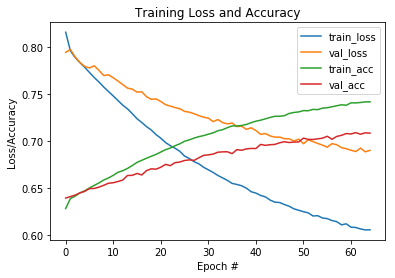

In [16]:
epoch_num = np.arange(0, 65)
plt.figure()
plt.plot(epoch_num, hist1.history["loss"], label="train_loss")
plt.plot(epoch_num, hist1.history["val_loss"], label="val_loss")
plt.plot(epoch_num, hist1.history["accuracy"], label="train_acc")
plt.plot(epoch_num, hist1.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('Lung Cancer ANN Epoch Plot')

Performance comparison between the Training Set and Test Set.

In [17]:
y_hat_train_class = model.predict_classes(train_data, verbose=1)
y_hat_test_class = model.predict_classes(test_data, verbose=1)

94330/94330 [==============================] - 6s 61us/step


In [18]:
print('Training Set Performance')
conf_matrix_ann = confusion_matrix(encoder.inverse_transform(encoded_train_target), encoder.inverse_transform(y_hat_train_class))
print(conf_matrix_ann)

cr_ann = classification_report(encoder.inverse_transform(encoded_train_target), encoder.inverse_transform(y_hat_train_class))
print(cr_ann)

Training Set Performance
[[101511  12868  11325]
 [ 29876  89692   6368]
 [ 10013   3411 112254]]
              precision    recall  f1-score   support

    0.5-2yrs       0.72      0.81      0.76    125704
   <=6months       0.85      0.71      0.77    125936
       >2yrs       0.86      0.89      0.88    125678

    accuracy                           0.80    377318
   macro avg       0.81      0.80      0.80    377318
weighted avg       0.81      0.80      0.80    377318



In [19]:
print('Test Set Performance')
conf_matrix_ann = confusion_matrix(encoder.inverse_transform(encoded_test_target), encoder.inverse_transform(y_hat_test_class))
print(conf_matrix_ann)

cr_ann = classification_report(encoder.inverse_transform(encoded_test_target), encoder.inverse_transform(y_hat_test_class))
print(cr_ann)

Test Set Performance
[[22157  5036  4319]
 [ 9452 19480  2348]
 [ 4967  1402 25169]]
              precision    recall  f1-score   support

    0.5-2yrs       0.61      0.70      0.65     31512
   <=6months       0.75      0.62      0.68     31280
       >2yrs       0.79      0.80      0.79     31538

    accuracy                           0.71     94330
   macro avg       0.72      0.71      0.71     94330
weighted avg       0.72      0.71      0.71     94330



## CNN Model 

For both the RNN and CNN models, we need the input to be 3-dimensional including the timesteps. Therefore, reshaping the 2-D array into 3-D space.

In [20]:
train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.2,random_state=101)

scaler=StandardScaler()
train_data=scaler.fit_transform(train_data)
test_data=scaler.transform(test_data)

train_data=train_data.reshape(train_data.shape[0],1,train_data.shape[1])
test_data=test_data.reshape(test_data.shape[0],1,test_data.shape[1])

encoder = LabelEncoder()
encoder.fit(train_target)
encoded_train_target = encoder.transform(train_target)
dummy_train_target = np_utils.to_categorical(encoded_train_target)

encoded_test_target=encoder.transform(test_target)
dummy_test_target = np_utils.to_categorical(encoded_test_target)

In [21]:
seed(100)
tensorflow.random.set_seed(100)

Defining the structure of the CNN with 2 hidden layers with [50,20] neurons each and ReLU activation function on the hidden layers and softmax activation on the output layer. The output layer has three neuron in line with the number of classes for prediction. 20% dropout layer is used after each hidden layer.

Loss Function- Categorical Crossentropy

Optimizer- ADAM

Observed Metrics- Accuracy

An initial fit of the model is developed over a large number of epochs to determine point of overfitting of the model.

In [24]:
#CNN
model=Sequential()
    
model.add(Conv1D(50, 1, input_shape=train_data.shape[1:], activation='relu'))
model.add(Dropout(0.2))
model.add(Conv1D(20, 1, activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(dummy_train_target.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
hist=model.fit(train_data, dummy_train_target, epochs=50, batch_size=200, verbose=1, validation_data=(test_data,dummy_test_target))

Train on 377318 samples, validate on 94330 samples
Epoch 1/50
377318/377318 [==============================] - 15s 39us/step - loss: 0.8514 - accuracy: 0.6149 - val_loss: 0.7974 - val_accuracy: 0.6363
Epoch 2/50
377318/377318 [==============================] - 14s 38us/step - loss: 0.8113 - accuracy: 0.6332 - val_loss: 0.7907 - val_accuracy: 0.6406
Epoch 3/50
377318/377318 [==============================] - 14s 38us/step - loss: 0.8045 - accuracy: 0.6351 - val_loss: 0.7889 - val_accuracy: 0.6409
Epoch 4/50
377318/377318 [==============================] - 14s 38us/step - loss: 0.8014 - accuracy: 0.6371 - val_loss: 0.7875 - val_accuracy: 0.6420
Epoch 5/50
377318/377318 [==============================] - 14s 38us/step - loss: 0.7987 - accuracy: 0.6383 - val_loss: 0.7850 - val_accuracy: 0.6427
Epoch 6/50
377318/377318 [==============================] - 14s 38us/step - loss: 0.7961 - accuracy: 0.6392 - val_loss: 0.7838 - val_accuracy: 0.6430
Epoch 7/50
377318/377318 [=======================

In [26]:
_, accuracy = model.evaluate(train_data, dummy_train_target)
_, test_accuracy = model.evaluate(test_data, dummy_test_target)

print('Train Accuracy=',accuracy)
print('Test Accuracy=',test_accuracy)

94330/94330 [==============================] - 2s 23us/step
Train Accuracy= 0.659247636795044
Test Accuracy= 0.648796796798706


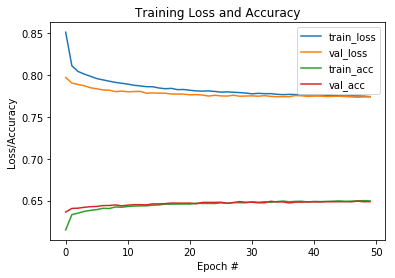

In [27]:
epoch_num = np.arange(0, 50)
plt.figure()
plt.plot(epoch_num, hist.history["loss"], label="train_loss")
plt.plot(epoch_num, hist.history["val_loss"], label="val_loss")
plt.plot(epoch_num, hist.history["accuracy"], label="train_acc")
plt.plot(epoch_num, hist.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('Lung Cancer CNN Epoch Plot')

Training set and Test Set Performance

In [28]:
y_hat_train_class = model.predict_classes(train_data, verbose=1)
y_hat_test_class = model.predict_classes(test_data, verbose=1)

94330/94330 [==============================] - 2s 19us/step


In [29]:
print('Training Set Performance')
conf_matrix_ann = confusion_matrix(encoder.inverse_transform(encoded_train_target), encoder.inverse_transform(y_hat_train_class))
print(conf_matrix_ann)

cr_ann = classification_report(encoder.inverse_transform(encoded_train_target), encoder.inverse_transform(y_hat_train_class))
print(cr_ann)

Training Set Performance
[[81719 25174 18811]
 [39717 80883  5336]
 [32823  6711 86144]]
              precision    recall  f1-score   support

    0.5-2yrs       0.53      0.65      0.58    125704
   <=6months       0.72      0.64      0.68    125936
       >2yrs       0.78      0.69      0.73    125678

    accuracy                           0.66    377318
   macro avg       0.68      0.66      0.66    377318
weighted avg       0.68      0.66      0.66    377318



In [30]:
print('Test Set Performance')
conf_matrix_ann = confusion_matrix(encoder.inverse_transform(encoded_test_target), encoder.inverse_transform(y_hat_test_class))
print(conf_matrix_ann)

cr_ann = classification_report(encoder.inverse_transform(encoded_test_target), encoder.inverse_transform(y_hat_test_class))
print(cr_ann)

Test Set Performance
[[20191  6387  4934]
 [10010 19772  1498]
 [ 8583  1717 21238]]
              precision    recall  f1-score   support

    0.5-2yrs       0.52      0.64      0.57     31512
   <=6months       0.71      0.63      0.67     31280
       >2yrs       0.77      0.67      0.72     31538

    accuracy                           0.65     94330
   macro avg       0.67      0.65      0.65     94330
weighted avg       0.67      0.65      0.65     94330



In [31]:
seed(100)
tensorflow.random.set_seed(100)

Defining the structure of the RNN with 2 hidden layers with [50,20] neurons each and ReLU activation function on the hidden layers and softmax activation on the output layer. The output layer has three neuron in line with the number of classes for prediction. 20% Dropout layer is used after each hidden layer.

Loss Function- Categorical Crossentropy

Optimizer- ADAM

Observed Metrics- Accuracy

An initial fit of the model is developed over a large number of epochs to determine point of overfitting of the model.

In [32]:
#RNN
model=Sequential()

model.add(LSTM(50, input_shape=train_data.shape[1:], return_sequences=True,activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(20, return_sequences=False,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(dummy_train_target.shape[1], activation='softmax'))
    
# model.add(LSTM(64, input_shape=train_data.shape[1:], return_sequences=True,activation='relu'))
# model.add(Dropout(0.2))
# model.add(LSTM(32, return_sequences=False,activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(dummy_train_target.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
hist=model.fit(train_data, dummy_train_target, epochs=50, batch_size=128, verbose=1, validation_data=(test_data,dummy_test_target))

Train on 377318 samples, validate on 94330 samples
Epoch 1/50
377318/377318 [==============================] - 23s 62us/step - loss: 0.8221 - accuracy: 0.6265 - val_loss: 0.7907 - val_accuracy: 0.6412
Epoch 2/50
377318/377318 [==============================] - 23s 61us/step - loss: 0.7991 - accuracy: 0.6388 - val_loss: 0.7872 - val_accuracy: 0.6434
Epoch 3/50
377318/377318 [==============================] - 23s 61us/step - loss: 0.7908 - accuracy: 0.6429 - val_loss: 0.7808 - val_accuracy: 0.6454
Epoch 4/50
377318/377318 [==============================] - 23s 61us/step - loss: 0.7847 - accuracy: 0.6458 - val_loss: 0.7779 - val_accuracy: 0.6472
Epoch 5/50
377318/377318 [==============================] - 25s 67us/step - loss: 0.7796 - accuracy: 0.6486 - val_loss: 0.7773 - val_accuracy: 0.6478
Epoch 6/50
377318/377318 [==============================] - 23s 61us/step - loss: 0.7755 - accuracy: 0.6514 - val_loss: 0.7745 - val_accuracy: 0.6497
Epoch 7/50
377318/377318 [=======================

In [34]:
_, accuracy = model.evaluate(train_data, dummy_train_target)
_, test_accuracy = model.evaluate(test_data, dummy_test_target)

print('Train Accuracy=',accuracy)
print('Test Accuracy=',test_accuracy)

94330/94330 [==============================] - 4s 40us/step
Train Accuracy= 0.7058210968971252
Test Accuracy= 0.6640623211860657


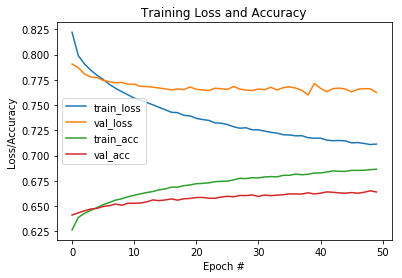

In [35]:
epoch_num = np.arange(0, 50)
plt.figure()
plt.plot(epoch_num, hist.history["loss"], label="train_loss")
plt.plot(epoch_num, hist.history["val_loss"], label="val_loss")
plt.plot(epoch_num, hist.history["accuracy"], label="train_acc")
plt.plot(epoch_num, hist.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('Lung Cancer RNN Epoch Plot')

Training Set and Test Performance.

In [36]:
y_hat_train_class = model.predict_classes(train_data, verbose=1)
y_hat_test_class = model.predict_classes(test_data, verbose=1)

94330/94330 [==============================] - 3s 33us/step


In [ ]:
print('Training Set Performance')
conf_matrix_ann = confusion_matrix(encoder.inverse_transform(encoded_train_target), encoder.inverse_transform(y_hat_train_class))
print(conf_matrix_ann)

cr_ann = classification_report(encoder.inverse_transform(encoded_train_target), encoder.inverse_transform(y_hat_train_class))
print(cr_ann)

In [37]:
print('Test Set Performance')
conf_matrix_ann = confusion_matrix(encoder.inverse_transform(encoded_test_target), encoder.inverse_transform(y_hat_test_class))
print(conf_matrix_ann)

cr_ann = classification_report(encoder.inverse_transform(encoded_test_target), encoder.inverse_transform(y_hat_test_class))
print(cr_ann)

Test Set Performance
[[19040  6557  5915]
 [ 9010 20012  2258]
 [ 6283  1666 23589]]
              precision    recall  f1-score   support

    0.5-2yrs       0.55      0.60      0.58     31512
   <=6months       0.71      0.64      0.67     31280
       >2yrs       0.74      0.75      0.75     31538

    accuracy                           0.66     94330
   macro avg       0.67      0.66      0.67     94330
weighted avg       0.67      0.66      0.67     94330

